## 1. Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib
matplotlib.use('Qt5agg')
import matplotlib.pyplot as plt
from pathlib import Path

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

distortion_correction_file = Path("./distortion_correction_pickle.p")
if distortion_correction_file.is_file():
    print('Distortion correction file already created')
else:
    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()

Distortion correction file already created


## 2. Apply distortion correction to test images and save the camera calibration result for later use
Use object points and image points to calculate distortion coefficients, and test undistortion on an image.

image size is (1280, 720)


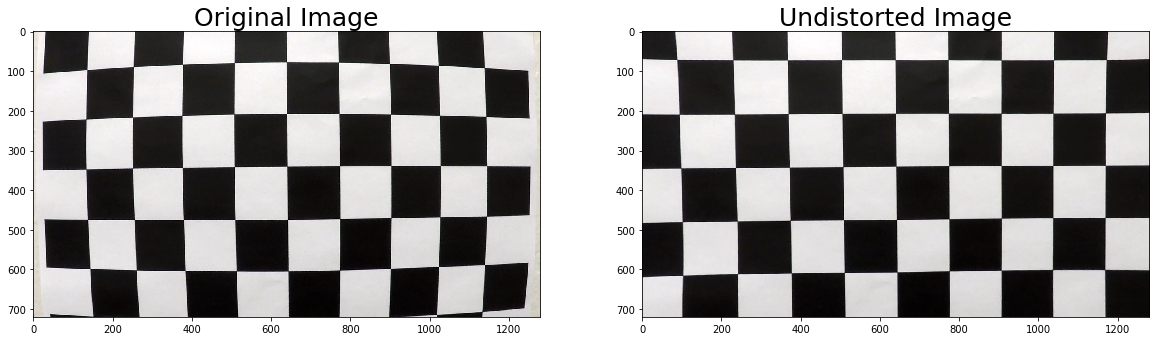

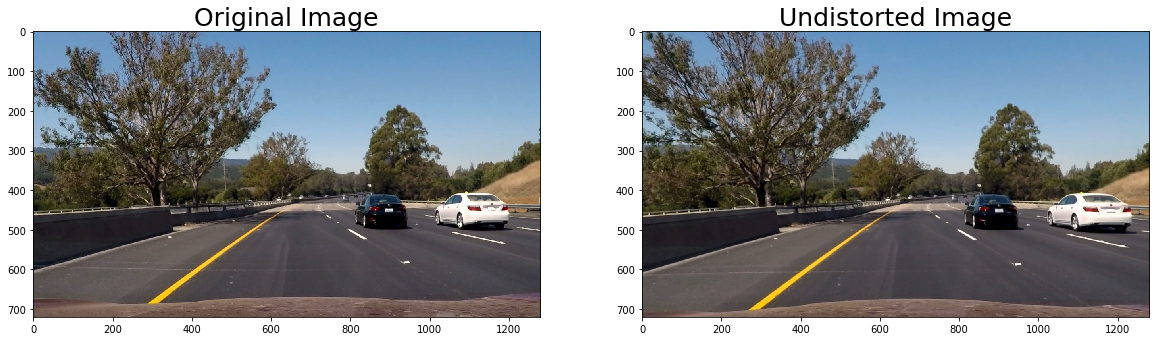

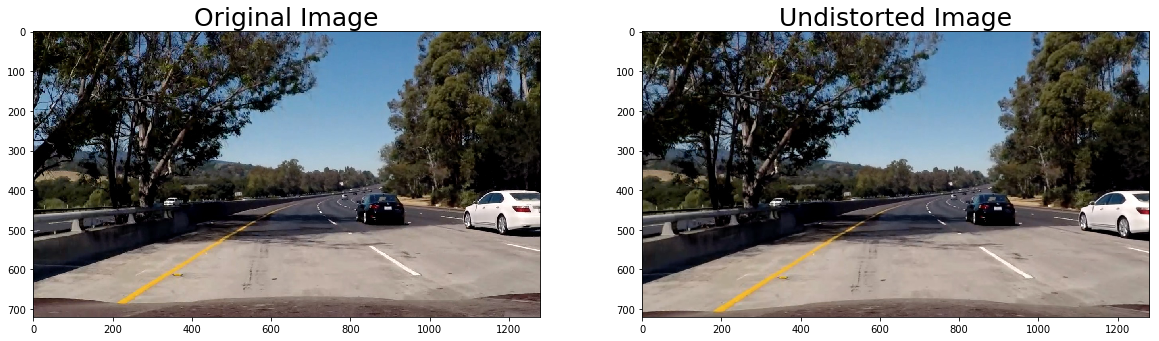

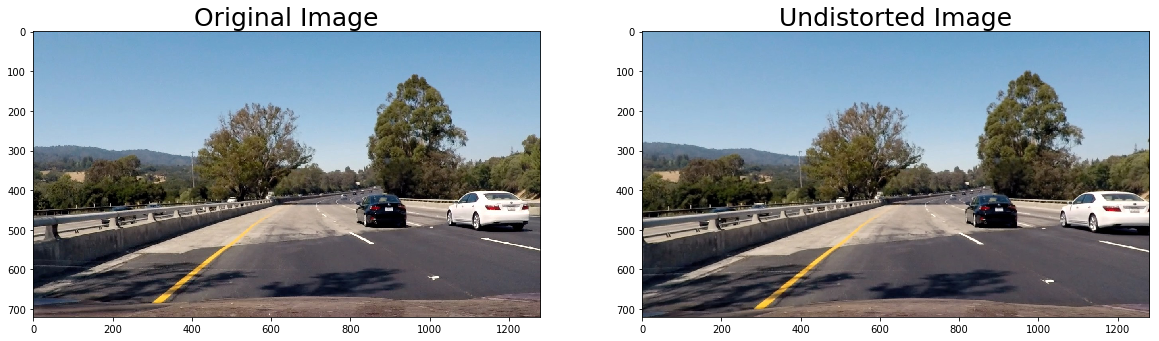

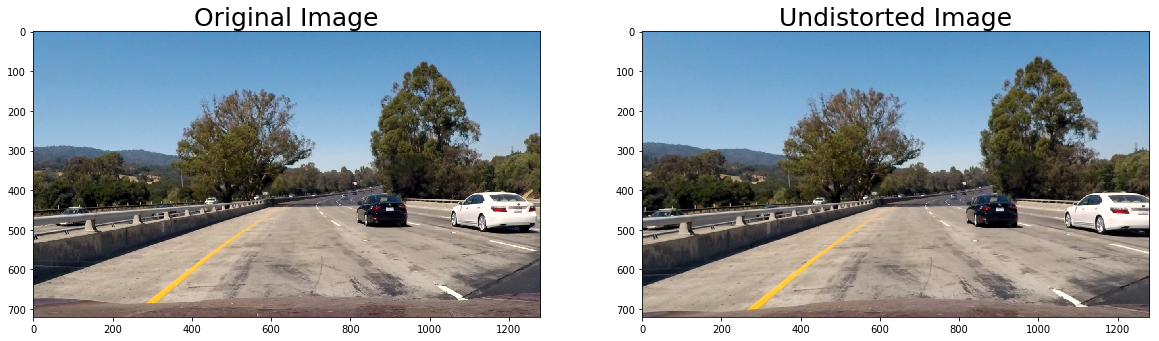

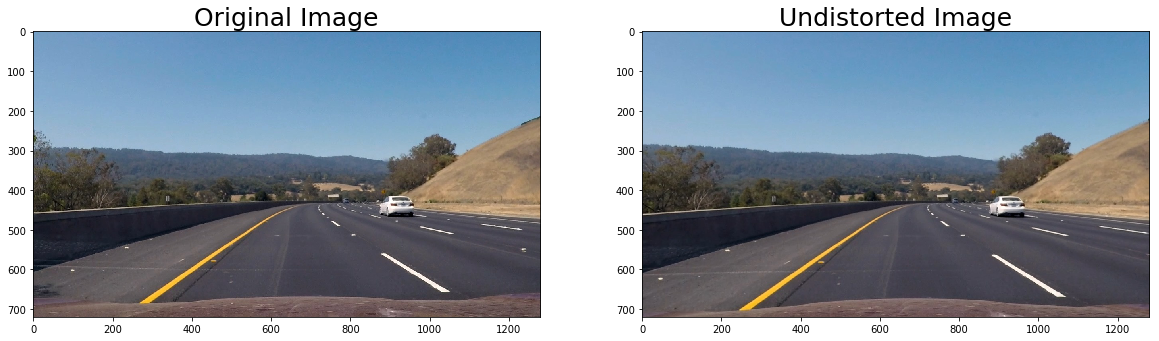

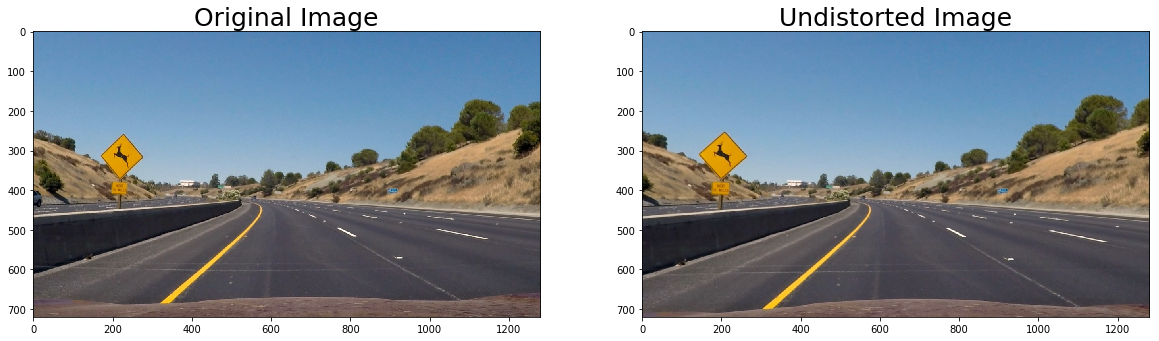

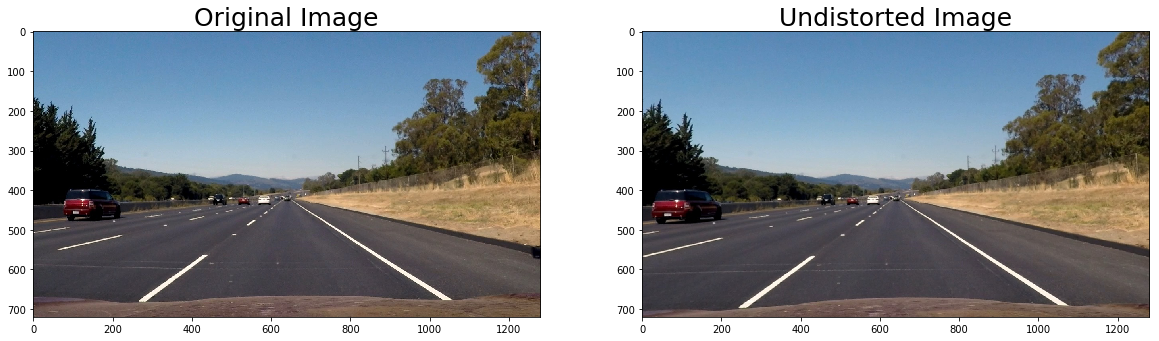

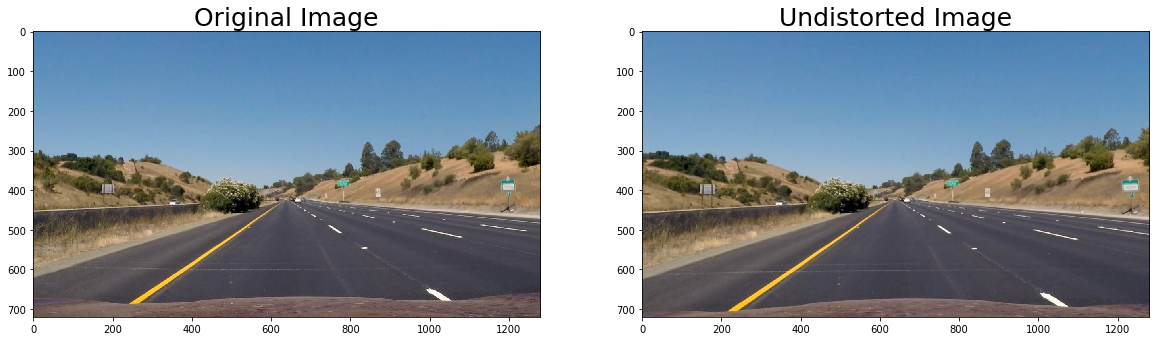

In [2]:
import pickle
%matplotlib inline

# Make a list of test images set 1
test_images_1 = glob.glob('./test_images/test*.jpg')
# Make a list of test images set 2
test_images_2 = glob.glob('./test_images/straight_lines*.jpg')
# Combine the test images set 1 and 2
test_images = test_images_1 + test_images_2

# Test undistortion on an image
test_img_path = './test_images/straight_lines1.jpg'
img = cv2.imread(test_img_path)
img_size = (img.shape[1], img.shape[0])
print('image size is {}'.format(img_size))

# check if we already created the calibration file with coefficients
if distortion_correction_file.is_file():
    # load the coefficients to undistort the camera image
    with open('./distortion_correction_pickle.p', mode='rb') as f:
        calibration_file = pickle.load(f)
        mtx, dist = calibration_file['mtx'], calibration_file['dist']
else:
    print('Calibration does not exist. Please run the cell above to create it first.')
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( './distortion_correction_pickle.p', 'wb' ) )

# apply distortion correction to the camera calibration image
filename = './camera_cal/calibration1.jpg'
img = cv2.imread(filename)
dst = cv2.undistort(img, mtx, dist, None, mtx)
# Process the file name for saving to a different directory
filename = filename.replace('./camera_cal/', '')
undistorted_filename = './output_images/' + 'undist_' + filename
cv2.imwrite(undistorted_filename, dst)
# Convert to RGB color space
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=25)    

# apply distortion correction to the test images
for filename in test_images:
    img = cv2.imread(filename)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Process the file name for saving to a different directory
    filename = filename.replace('./test_images/', '')
    undistorted_filename = './output_images/' + 'undist_' + filename
    cv2.imwrite(undistorted_filename, dst)
    # Convert to RGB color space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=25)



## 3. Apply the perspective transform to convert the binary image to a birds-eye view.

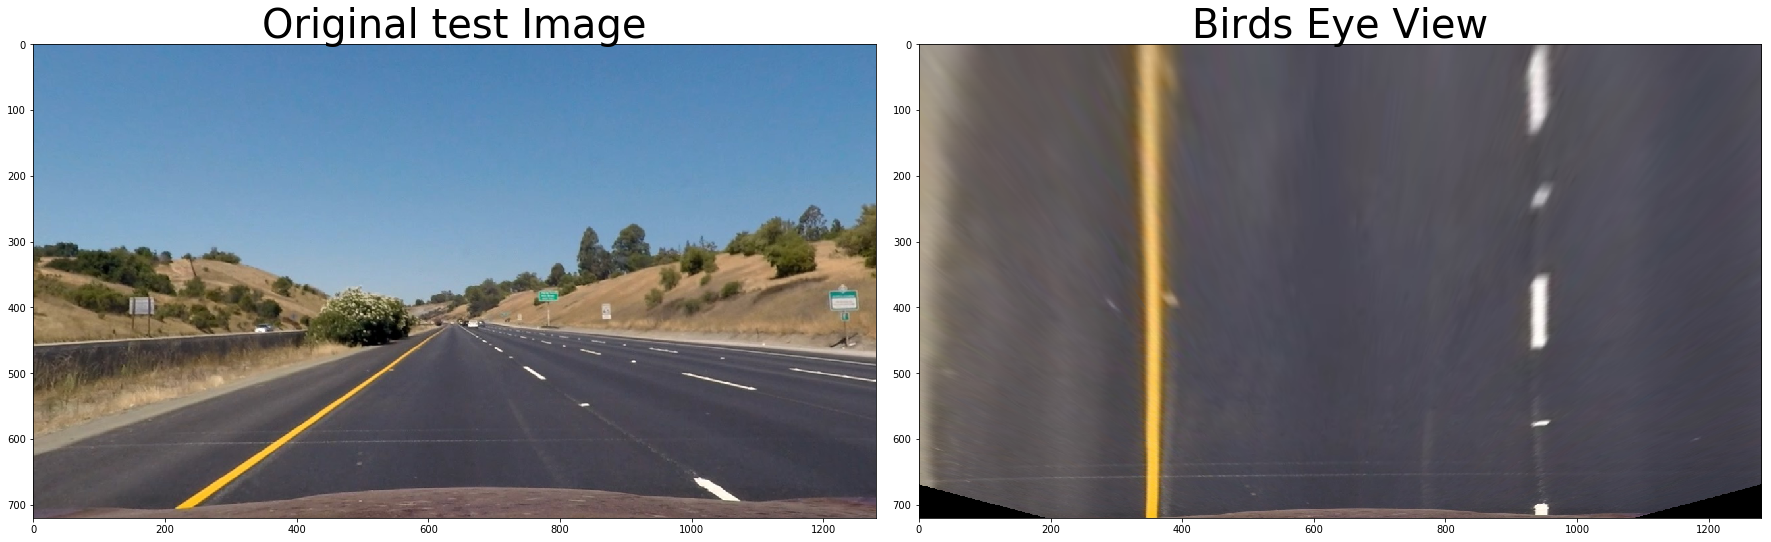

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import img_as_uint
from skimage import io

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh=(20, 100), sobel_kernel=3):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image

    return grad_binary

# def pipeline(img, h_thresh = (14, 24), s_thresh=(75, 255), 
#              white_h_thresh = (0, 179), white_s_thresh=(1, 25), white_v_thresh = (200, 255), 
#              sx_thresh=(20, 100), sy_thresh=(20, 100),
#              dir_thresh = (25,75), 
#              sobel_kernel=3):
#     img = np.copy(img)
#     # Convert to HSV color space and separate the V channel
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
#     h_channel = hsv[:,:,0]
#     s_channel = hsv[:,:,1]
#     v_channel = hsv[:,:,2]

#     # Threshold x gradient
#     sxbinary = abs_sobel_thresh(img, orient='x', thresh=(20, 100))
            
#     # Threshold the hue channel
#     # yellow hue
#     h_binary = np.zeros_like(h_channel)
#     h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
#     # white hue (basically anything)
#     white_h_binary = np.zeros_like(h_channel)
#     white_h_binary[(h_channel >= white_h_thresh[0]) & (h_channel <= white_h_thresh[1])] = 1 
    
#     # Threshold saturation channel
#     # yellow saturation
#     s_binary = np.zeros_like(s_channel)
#     s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
#     # white saturation (very low)
#     white_s_binary = np.zeros_like(s_channel)
#     white_s_binary[(s_channel >= white_s_thresh[0]) & (s_channel <= white_s_thresh[1])] = 1
    
#     # Threshold v channel
#     white_v_binary = np.zeros_like(v_channel)
#     white_v_binary[(v_channel >= white_v_thresh[0]) & (v_channel <= white_v_thresh[1])] = 1    
    
#     combined_output = np.zeros_like(s_channel)
#     binary_output1 = np.zeros_like(s_channel)
#     binary_output2 = np.zeros_like(s_channel)
#     binary_output3 = np.zeros_like(s_channel)
    
#     binary_output1[((sxbinary ==1) | (s_binary == 1)) & (h_binary==1)] = 1 # yellow line
#     binary_output2[(sxbinary == 1) & ((white_s_binary == 1) & (white_h_binary==1))] = 1 #  white line 1
#     binary_output3[(sxbinary == 1) | ((white_v_binary == 1) & (white_s_binary == 1) & (white_h_binary==1))] = 1 # white line 2
    
#     combined_output[(binary_output1 == 1) | (binary_output2 == 1) | (binary_output3 == 1)] = 1

#     # Stack each channel to visualize the effect of each output
#     color_binary = np.dstack((binary_output1, binary_output2, binary_output3))
#     #return b+w binary and color_binary
#     return combined_output, color_binary

# Read in a test image
test_img = './test_images/test5.jpg'
# test_img = './test_images/straight_lines1.jpg'
# test_img = './test_images/challenge.jpg'
# test_img = './test_images/cement2.jpg'
# test_img = './test_images/FirstFrame.jpg'

image = mpimg.imread(test_img) # use the test image from previous cell
image = mpimg.imread(test_img_path)
undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
# global parameters
corners = [(576,460), (705,460), (1102, 705),(180, 705)]
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([[320,0],[960, 0],[960, 720],[320, 720]])
# result, result_color = pipeline(undistort_img)

def perspective_warp(img):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped

def erode_image(img, k_size=(3,3)):
    kernel = np.ones(k_size,np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 1)
    return erosion

def draw_polyline(img, pts):
    # Draw a polygon
    pts = pts.reshape((-1,1,2))
    pts = np.int32(pts) # convert float to int to avoid errors
    cv2.polylines(img,[pts],True,(255,0,0), 2)
    return img


# # test
# birds_eye = perspective_warp(result)
# eroded_birds_eye = erode_image(birds_eye)

# # Plot the result
# #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# #f.tight_layout()

# ax1.imshow(result, cmap='gray')
# ax1.set_title('Binary Image', fontsize=40)

# ax2.imshow(birds_eye, cmap='gray')
# ax2.set_title('Binary Birds Eye View', fontsize=40)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# # save the result to disk
# io.imsave('./output_images/birds_eye.jpg', img_as_uint(birds_eye))

# original test image!!
# plot the image with warp
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax3.imshow(undistort_img)
ax3.set_title('Original test Image', fontsize=40)

warped_image = perspective_warp(undistort_img)
warped_cv2_image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('./warped_image.jpg', warped_cv2_image)
ax4.imshow(warped_image)
ax4.set_title('Birds Eye View', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# # save the result to disk
# io.imsave('./output_images/warped_image.jpg', img_as_uint(warped_image))

# # plot the binary image with erosion
# #f, (ax5, ax6) = plt.subplots(1, 2, figsize=(24, 9))
# #f.tight_layout()

# ax5.imshow(birds_eye, cmap='gray')
# ax5.set_title('Binary Birds Eye View', fontsize=40)

# ax6.imshow(eroded_birds_eye, cmap='gray')
# ax6.set_title('Eroded Binary Birds Eye View', fontsize=40)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# # plot polyline to verify lines are parallel
# #f, (ax7, ax8) = plt.subplots(1, 2, figsize=(24, 9))
# #f.tight_layout()

# image = mpimg.imread('./test_images/straight_lines1.jpg') # use the test image with straight lines
# undistorted_straight_line_img = cv2.undistort(image, mtx, dist, None, mtx)
# polyline_img = draw_polyline(undistorted_straight_line_img, src)
# ax7.imshow(polyline_img)
# ax7.set_title('Undistorted image with source points drawn', fontsize=40)
# io.imsave('./output_images/undistorted_img_w_source_pts.jpg', img_as_uint(undistorted_straight_line_img))

# warped_polyline_img = perspective_warp(polyline_img)
# ax8.imshow(warped_polyline_img)
# ax8.set_title('Warped result with dest. point drawn', fontsize=40)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# io.imsave('./output_images/warped_result_w_dest_pts.jpg', img_as_uint(warped_polyline_img))

## 15. Video processing pipeline

In [4]:
# set global variables
# first_image = True
# left_line = Line()
# right_line = Line()
# line_check_fault_counter = 0
def process_image(image, debug_info = False):
    global first_image
#     global left_line, right_line
#     global line_check_fault_counter
    # undistort the image
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    # feed the image to the color/gradient thresholding pipeline
    # to create a binary image
#     result, result_color = pipeline(undistort_img)
    
    # unwarp the binary image to a birds eye view
    birds_eye = perspective_warp(undistort_img)
    
    # Fit a second order polynomial for left and right line
#    l_line, r_line, last_l_line, last_r_line = polynomial_fit(birds_eye, left_line, right_line, 
#                                                              line_check_fault_counter, fault_thres = 5)
#    info = None
        
    # sanity check for lines
#    if ((line_check(l_line, r_line) is True) or (first_image is True)):

#         first_image = False
#         # save data from this frame for the next loop
#         left_line = l_line
#         right_line = r_line
                   
        # Warp the lane boundary back to the original image, with the best fitted x values
#         result = map_lane(undistort_img, birds_eye, 
#                           left_line.current_fit, right_line.current_fit,
#                           left_line.bestx, right_line.bestx,
#                           use_bestfit = True)
        
        # measure car's offset from the lane center
#         offset, side = measure_offset_from_lane_center(birds_eye, left_line.current_fit, right_line.current_fit)
#         # clear the counter
#         line_check_fault_counter = 0
#     else:
#         # save data from this frame for the next loop
#         left_line = last_l_line
#         right_line = last_r_line
               
#         # Warp the lane boundary back to the original image, with the best fitted x values
#         result = map_lane(undistort_img, birds_eye, 
#                           left_line.current_fit, right_line.current_fit,
#                           left_line.bestx, right_line.bestx,
#                           use_bestfit = True)
        
#         # measure car's offset from the lane center
#         offset, side = measure_offset_from_lane_center(birds_eye, left_line.current_fit, right_line.current_fit)
#         # line check fails, so increment the fault counter
#         line_check_fault_counter += 1 

#     # display curvature and car offset from center on the screen
#     info = 'Vehicle is ' + str(offset) + 'm ' + side + ' of center'
#     display_car_offset(result, info)     
#     display_text(result, left_line, right_line)
  
#     if (debug_info is True):
#         display_fault_counter(result, str(line_check_fault_counter), 
#                               str(fault_similar_curve), 
#                               str(fault_curve_ratio), 
#                               str(fault_curve_distance),
#                               str(use_window))
    return birds_eye

## 16. Test the video

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'finished_project_video.mp4'
input_clip = VideoFileClip("project_video.mp4")
output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video finished_project_video.mp4
[MoviePy] Writing video finished_project_video.mp4


100%|█████████▉| 1260/1261 [00:39<00:00, 31.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: finished_project_video.mp4 

CPU times: user 1min 8s, sys: 6.76 s, total: 1min 15s
Wall time: 40.6 s
